<a href="https://colab.research.google.com/github/Sebastian-Torres-Gamboa/SenalesSistemas/blob/main/Copia_de_AR_intento_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 kB 28.2 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.9.0-cp312-cp312-linux_x86_64.whl size=236767 sha256=28b57e4e0ce40cee43496b373353ed06f077649e9412a97e629ac1740925357f
  Stored in directory: /root/.cache/pip/wheels/19/a0/e0/e04656d89dd723adbe6ea41ab5fe702f5d4ccf95653eb54b04
Successfully built spectrum


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from google.colab import drive
import os
import shutil
from datetime import datetime

In [ ]:
def generate_synthetic_data(num_samples, num_points):
    """
    Generates varied synthetic time-series data with a random DC offset.
    """
    data = []
    for _ in range(num_samples):
        a = np.random.uniform(0.5, 5.0)
        f = np.random.uniform(10.0, 200.0)
        noise_std = np.random.uniform(0.1, 1.0)
        dc_offset = np.random.uniform(-5.0, 5.0)
        noise = np.random.normal(0, noise_std, num_points)
        t = np.linspace(0, 1, num_points)
        sine_wave = a * np.sin(2 * np.pi * f * t)
        signal = sine_wave + noise + dc_offset
        data.append(signal)
    return pd.DataFrame(data)

def calculate_psd(data, method='periodogram', nfft=1024):
    """
    Calculates the Power Spectral Density (PSD) of the data.
    """
    psd_data = []
    for row in data:
        if method == 'periodogram':
            _, pxx = signal.periodogram(row, nfft=nfft)
        elif method == 'welch':
            _, pxx = signal.welch(row, nfft=nfft)
        elif method == 'ar':
            from spectrum import pyule
            ar_model = pyule(row, order=10, NFFT=nfft)
            pxx = ar_model.psd
        psd_data.append(pxx)
    return np.array(psd_data)

def split_data(features, labels, test_size=0.15, validation_size=0.15):
    """
    Splits the data into training, validation, and testing sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(
        features, labels, test_size=(test_size + validation_size), random_state=42
    )
    relative_test_size = test_size / (test_size + validation_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=relative_test_size, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_psd_model(input_shape, output_shape):
    """
    Creates a robust feedforward neural network with Dropout for regularization.
    """
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(output_shape, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Trains the neural network model with advanced callbacks.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    return model, history

def plot_training_history(history):
    """
    Plots the training and validation loss.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained model on the test data.
    """
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {loss}')

--- STAGE 1: Training Periodogram Model (Synthetic Data Only) ---
Epoch 1/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.0327 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0027 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9891 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 4/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9891 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 5/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9762 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 6/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9204 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 7/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8688 - val_loss: 0.8138 - learning_rate: 0.0010
Epoch 8/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8236 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 9/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4

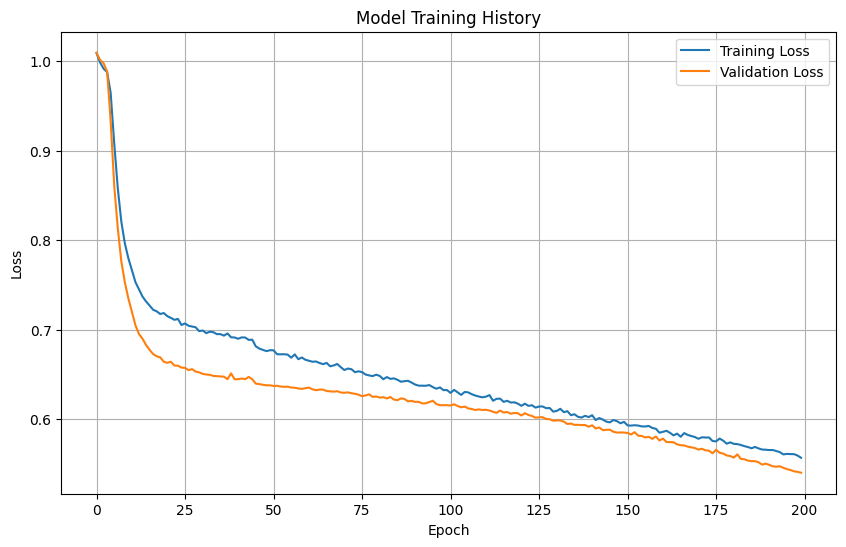

Test Loss: 0.5421974062919617
--- Stage 1 Complete ---


In [ ]:
print("--- STAGE 1: Training Periodogram Model (Synthetic Data Only) ---")
# 1. Generate Data
synthetic_data_pd = generate_synthetic_data(num_samples=50000, num_points=1024)

# 2. Preprocess Data
features_pd = synthetic_data_pd.values
labels_pd = calculate_psd(features_pd, method='periodogram', nfft=1024)

feature_scaler_pd = StandardScaler()
label_scaler_pd = StandardScaler()
X_train_pd, X_val_pd, X_test_pd, y_train_pd, y_val_pd, y_test_pd = split_data(features_pd, labels_pd)

X_train_pd_scaled = feature_scaler_pd.fit_transform(X_train_pd)
X_val_pd_scaled = feature_scaler_pd.transform(X_val_pd)
X_test_pd_scaled = feature_scaler_pd.transform(X_test_pd)
y_train_pd_scaled = label_scaler_pd.fit_transform(y_train_pd)
y_val_pd_scaled = label_scaler_pd.transform(y_val_pd)
y_test_pd_scaled = label_scaler_pd.transform(y_test_pd)

# 3. Create and Train Model
model_pd = create_psd_model(X_train_pd_scaled.shape[1], y_train_pd_scaled.shape[1])
trained_model_pd, history_pd = train_model(model_pd, X_train_pd_scaled, y_train_pd_scaled, X_val_pd_scaled, y_val_pd_scaled, epochs=200, batch_size=256)

# 4. Evaluate and Plot
plot_training_history(history_pd)
evaluate_model(trained_model_pd, X_test_pd_scaled, y_test_pd_scaled)
print("--- Stage 1 Complete ---")



--- STAGE 2: Pre-training AR Model (Synthetic Data Only) ---
Epoch 1/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.0269 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 2/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9561 - val_loss: 0.8255 - learning_rate: 0.0010
Epoch 3/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8559 - val_loss: 0.7837 - learning_rate: 0.0010
Epoch 4/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8058 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 5/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7719 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 6/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7666 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 7/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7579 - val_loss: 0.7109 - learning_rate: 0.0010
Epoch 8/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7512 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 9/200
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

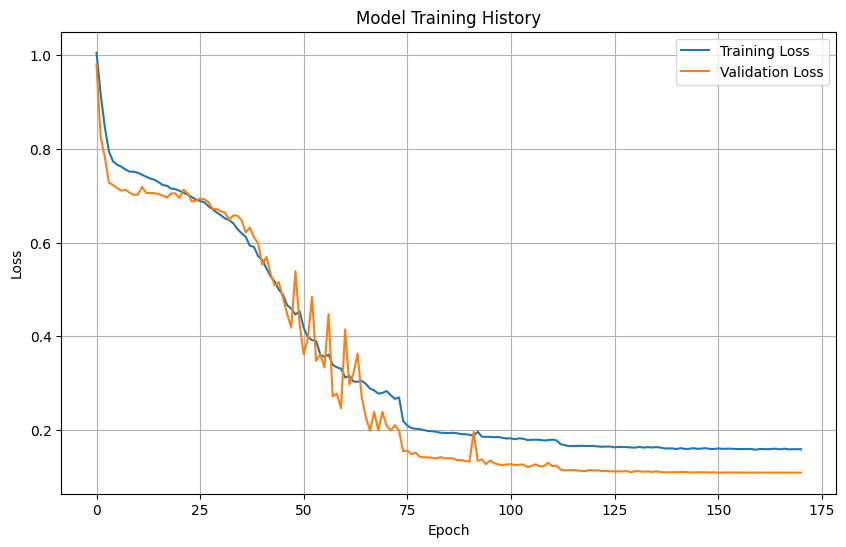

Test Loss: 0.11124297976493835
--- Stage 2 Complete ---


In [ ]:
print("\n\n--- STAGE 2: Pre-training AR Model (Synthetic Data Only) ---")
# 1. Generate Data
synthetic_data_ar = generate_synthetic_data(num_samples=75000, num_points=1024)

# 2. Preprocess Data with Log Transform
features_ar = synthetic_data_ar.values
labels_ar = calculate_psd(features_ar, method='ar', nfft=1024)
labels_ar_log = np.log1p(labels_ar)

feature_scaler_ar_synth = StandardScaler()
label_scaler_ar_synth = StandardScaler()
X_train_ar, X_val_ar, X_test_ar, y_train_ar, y_val_ar, y_test_ar = split_data(features_ar, labels_ar_log)

X_train_ar_scaled = feature_scaler_ar_synth.fit_transform(X_train_ar)
X_val_ar_scaled = feature_scaler_ar_synth.transform(X_val_ar)
X_test_ar_scaled = feature_scaler_ar_synth.transform(X_test_ar)
y_train_ar_scaled = label_scaler_ar_synth.fit_transform(y_train_ar)
y_val_ar_scaled = label_scaler_ar_synth.transform(y_val_ar)
y_test_ar_scaled = label_scaler_ar_synth.transform(y_test_ar)

# 3. Create and Train Model
model_ar_pretrained = create_psd_model(X_train_ar_scaled.shape[1], y_train_ar_scaled.shape[1])
trained_model_ar_pretrained, history_ar_pretrained = train_model(model_ar_pretrained, X_train_ar_scaled, y_train_ar_scaled, X_val_ar_scaled, y_val_ar_scaled, epochs=200, batch_size=256)

# 4. Evaluate and Plot
plot_training_history(history_ar_pretrained)
evaluate_model(trained_model_ar_pretrained, X_test_ar_scaled, y_test_ar_scaled)
print("--- Stage 2 Complete ---")



--- STAGE 3: Fine-Tuning AR Model (CSV Data) ---
Created fine-tuning dataset with 1677 training and 297 validation samples.
Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 5.1193 - val_loss: 0.5590 - learning_rate: 1.0000e-04
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4304 - val_loss: 0.4608 - learning_rate: 1.0000e-04
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3479 - val_loss: 0.4109 - learning_rate: 1.0000e-04
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2906 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2636 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2146 - val_loss: 0.2295 - learning_rate: 1.0000e-04
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2441 - val_loss: 0.1872 - learning_rate: 1.0000e-04
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2196 - val_loss: 0.17

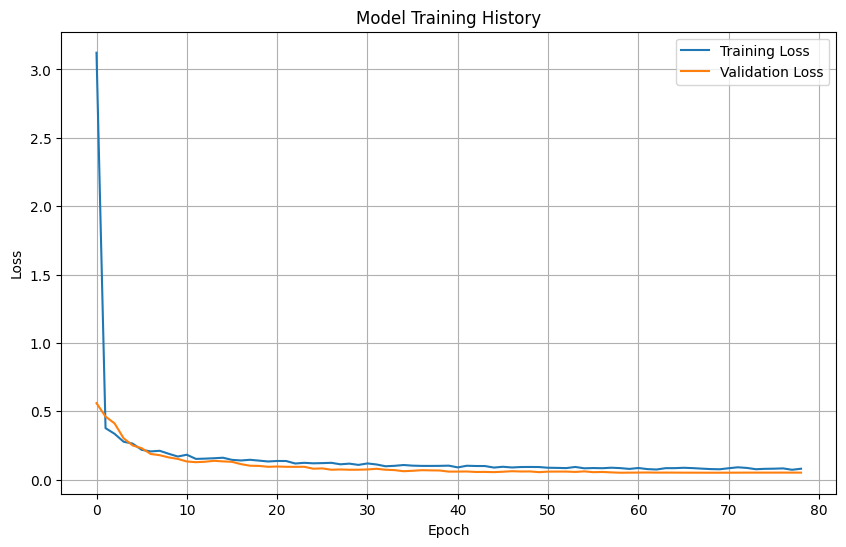


Verifying final model performance on held-out test column...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


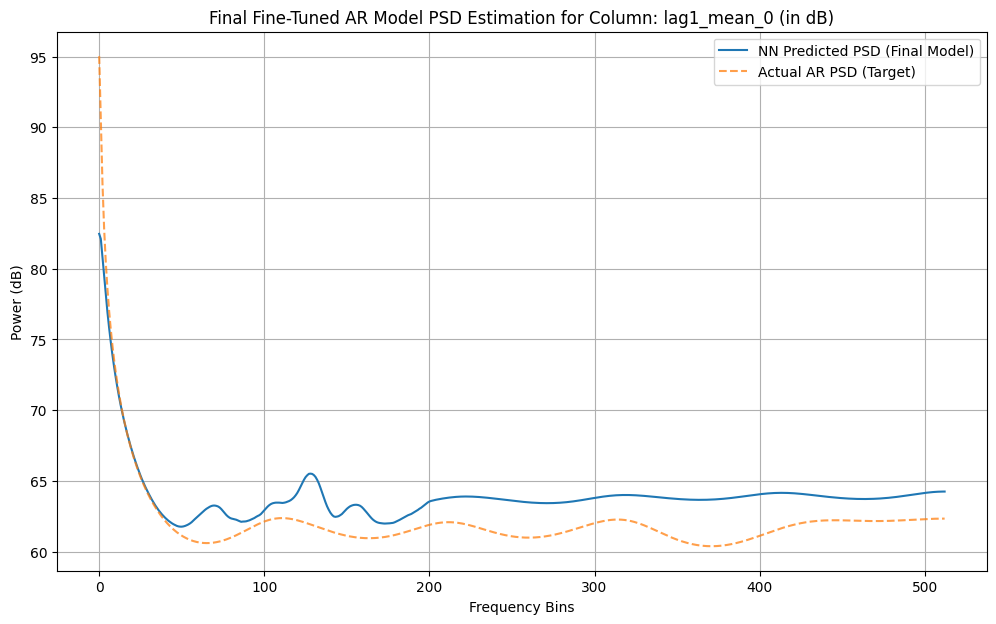

--- Stage 3 Complete ---


In [ ]:
print("\n\n--- STAGE 3: Fine-Tuning AR Model (CSV Data) ---")
# 1. Load the pre-trained model from the previous stage
final_model = trained_model_ar_pretrained

# 2. Prepare the fine-tuning dataset from the CSV
url = 'https://raw.githubusercontent.com/jomendietad/mental-state-analysis/main/mental-state.csv'
df = pd.read_csv(url)
test_column = 'lag1_mean_0'
train_columns = [col for col in df.columns if col not in [test_column, 'Label']]
all_chunks = []
for col in train_columns:
    signal_data = df[col].dropna().values
    chunks = [signal_data[i:i + 1024] for i in range(0, len(signal_data), 1024)]
    if len(chunks) > 0 and len(chunks[-1]) < 1024: chunks.pop()
    if chunks: all_chunks.extend(chunks)

# 3. Create and fit new scalers for the CSV data domain
finetune_feature_scaler = StandardScaler()
finetune_label_scaler = StandardScaler()
X_all_csv = np.array(all_chunks)
y_all_csv_actual = calculate_psd(X_all_csv, method='ar', nfft=1024)
y_all_csv_log = np.log1p(y_all_csv_actual)
X_train_ft, X_val_ft, y_train_ft, y_val_ft = train_test_split(X_all_csv, y_all_csv_log, test_size=0.15, random_state=42)

X_train_ft_scaled = finetune_feature_scaler.fit_transform(X_train_ft)
X_val_ft_scaled = finetune_feature_scaler.transform(X_val_ft)
y_train_ft_scaled = finetune_label_scaler.fit_transform(y_train_ft)
y_val_ft_scaled = finetune_label_scaler.transform(y_val_ft)
print(f"Created fine-tuning dataset with {len(X_train_ft)} training and {len(X_val_ft)} validation samples.")

# 4. Fine-tune the model
final_model.optimizer.learning_rate = 1e-4
final_model, history_final = train_model(final_model, X_train_ft_scaled, y_train_ft_scaled, X_val_ft_scaled, y_val_ft_scaled, epochs=200, batch_size=32)

# 5. Evaluate, Plot, and Verify
plot_training_history(history_final)
print("\nVerifying final model performance on held-out test column...")
test_signal_data = df[test_column].dropna().values
test_chunks = [test_signal_data[i:i + 1024] for i in range(0, len(test_signal_data), 1024)]
if len(test_chunks) > 0 and len(test_chunks[-1]) < 1024: test_chunks.pop()
X_test_final = np.array(test_chunks)
y_test_final_actual = calculate_psd(X_test_final, method='ar', nfft=1024)
X_test_final_scaled = finetune_feature_scaler.transform(X_test_final)
predicted_psds_scaled = final_model.predict(X_test_final_scaled)
predicted_psds_log = finetune_label_scaler.inverse_transform(predicted_psds_scaled)
predicted_psds = np.expm1(predicted_psds_log)
averaged_psd = np.mean(predicted_psds, axis=0)
epsilon = 1e-10
averaged_psd_db = 10 * np.log10(averaged_psd + epsilon)
averaged_actual_ar_psd_db = 10 * np.log10(np.mean(y_test_final_actual, axis=0) + epsilon)
plt.figure(figsize=(12, 7))
plt.plot(averaged_psd_db, label='NN Predicted PSD (Final Model)')
plt.plot(averaged_actual_ar_psd_db, label='Actual AR PSD (Target)', alpha=0.75, linestyle='--')
plt.title(f'Final Fine-Tuned AR Model PSD Estimation for Column: {test_column} (in dB)')
plt.xlabel('Frequency Bins')
plt.ylabel('Power (dB)')
plt.legend()
plt.grid(True)
plt.show()
print("--- Stage 3 Complete ---")

In [ ]:
print("\n\n--- FINAL STEP: Saving All Models to Google Drive ---")

# 1. Mount Google Drive
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error mounting Drive: {e}")
    exit()

# 2. Create a single, timestamped folder for this entire run
base_drive_path = '/content/drive/My Drive/PSD_Model_Archive/'
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
run_folder_path = os.path.join(base_drive_path, f'run_{timestamp}')
os.makedirs(run_folder_path, exist_ok=True)
print(f"Created main run folder: {run_folder_path}")

# 3. Create a dictionary of all models and their components to save
models_to_save = {
    "Periodogram_Synth_Only": (trained_model_pd, feature_scaler_pd, label_scaler_pd),
    "AR_Pretrained_Synth_Only": (trained_model_ar_pretrained, feature_scaler_ar_synth, label_scaler_ar_synth),
    "AR_Finetuned_on_CSV": (final_model, finetune_feature_scaler, finetune_label_scaler)
}

# 4. Loop through the dictionary and save each model in its own subfolder
for description, (model, fs, ls) in models_to_save.items():
    print(f"\nSaving model: {description}...")
    # Create the specific subfolder for this model
    model_subfolder_path = os.path.join(run_folder_path, description)
    os.makedirs(model_subfolder_path, exist_ok=True)

    # Save the components to the subfolder
    model.save(os.path.join(model_subfolder_path, 'model.keras'))
    joblib.dump(fs, os.path.join(model_subfolder_path, 'feature_scaler.joblib'))
    joblib.dump(ls, os.path.join(model_subfolder_path, 'label_scaler.joblib'))
    print(f"Successfully saved '{description}'")

print("\n--- All models for this run have been archived to Google Drive. ---")



--- FINAL STEP: Saving All Models to Google Drive ---
Mounted at /content/drive
Created main run folder: /content/drive/My Drive/PSD_Model_Archive/run_2025-10-16_23-09-00

Saving model: Periodogram_Synth_Only...
Successfully saved 'Periodogram_Synth_Only'

Saving model: AR_Pretrained_Synth_Only...
Successfully saved 'AR_Pretrained_Synth_Only'

Saving model: AR_Finetuned_on_CSV...
Successfully saved 'AR_Finetuned_on_CSV'

--- All models for this run have been archived to Google Drive. ---
